# TensorFlow Lattice estimators
In this tutorial, we will cover basics of TensorFlow Lattice estimators.

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_lattice as tfl
import tempfile
from six.moves import urllib

# Synthetic dataset
Here we create a synthetic dataset.

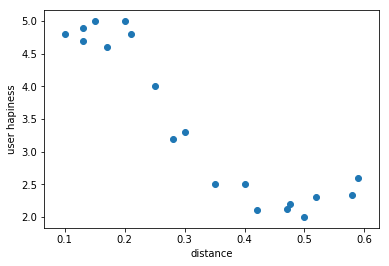

In [2]:
%matplotlib inline

# Training dataset contains one feature, "distance".
train_features = {
    'distance': np.array([1.0, 1.3, 1.5, 2.0, 2.1, 3.0,
                          4.0, 5.0, 1.3, 1.7, 2.5, 2.8,
                          4.7, 4.2, 3.5, 4.75, 5.2,
                          5.8, 5.9]) * 0.1, 
}
train_labels = np.array([4.8, 4.9, 5.0, 5.0,
                         4.8, 3.3, 2.5, 2.0,
                         4.7, 4.6, 4.0, 3.2,
                         2.12, 2.1, 2.5, 2.2,
                         2.3, 2.34, 2.6])
plt.scatter(train_features['distance'], train_labels)
plt.xlabel('distance')
plt.ylabel('user hapiness')

In [20]:
# This function draws two plots.
# Firstly, we draw the scatter plot of `distance` vs. `label`.
# Secondly, we generate predictions from `estimator` distance ranges in
# [xmin, xmax]. 
def Plot(distance, label, estimator, xmin=0.0, xmax=10.0):
    %matplotlib inline
    test_features = {
        'distance': np.linspace(xmin, xmax, num=100)
    }
    # Estimator accepts an input in the form of input_fn (callable).
    # numpy_input_fn creates an input function that generates a dictionary where
    # the key is a feaeture name ('distance'), and the value is a tensor with
    # a shape [batch_size, 1].
    test_input_fn = tf.estimator.inputs.numpy_input_fn(
        x=test_features,
        batch_size=1,
        num_epochs=1,
        shuffle=False)
    # Estimator's prediction is 1d tensor with a shape [batch_size]. Since we
    # set batch_size == 1 in the above, p['predictions'] will contain only one
    # element in each batch, and we fetch this value by p['predictions'][0].
    predictions = [p['predictions'][0]
                   for p in estimator.predict(input_fn=test_input_fn)]
    
    # Plot estimator's response and (distance, label) scatter plot.
    fig, ax = plt.subplots(1, 1)
    ax.plot(test_features['distance'], predictions)
    ax.scatter(distance, label)
    plt.xlabel('distance')
    plt.ylabel('user hapiness')
    plt.legend(['prediction', 'data'])

# DNN Estimator
Now let us define feature columns and use DNN regressor to fit a model.

In [21]:
# Specify feature.
feature_columns = [
    tf.feature_column.numeric_column('distance'),
]
# Define a neural network legressor.
# The first hidden layer contains 30 hidden units, and the second
# hidden layer contains 10 hidden units.
dnn_estimator = tf.estimator.DNNRegressor(
    feature_columns=feature_columns,
    hidden_units=[30, 10],
    optimizer=tf.train.GradientDescentOptimizer(
      learning_rate=0.01,
    ),
)

# Define training input function.
# mini-batch size is 10, and we iterate the dataset over
# 1000 times.
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=train_features,
    y=train_labels,
    batch_size=10,
    num_epochs=1000,
    shuffle=False)

tf.logging.set_verbosity(tf.logging.ERROR)
# Train this estimator
dnn_estimator.train(input_fn=train_input_fn)

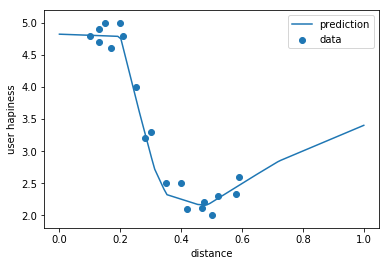

In [23]:
# Response in [0.0, 1.0] range
Plot(train_features['distance'], train_labels, dnn_estimator, 0.0, 1.0)

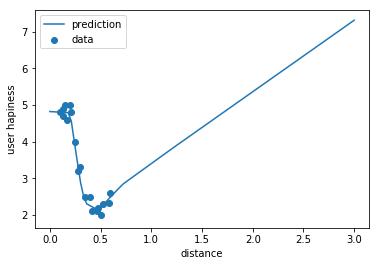

In [24]:
# Now let's increase the prediction range to [0.0, 3.0]
# Note) In most machines, the prediction is going up.
# However, DNN training does not have a unique solution, so it's possible
# not to see this phenomenon.
Plot(train_features['distance'], train_labels, dnn_estimator, 0.0, 3.0)

# TensorFlow Lattice calibrated linear model
Let's use calibrated linear model to fit the data.
Since we only have one example, there's no reason to use a lattice.

In [63]:
# TensorFlow Lattice needs feature names to specify
# per-feature parameters.
feature_names = [fc.name for fc in feature_columns]
num_keypoints = 20

hparams = tfl.CalibratedLinearHParams(
    feature_names=feature_names,
    learning_rate=0.1,
    num_keypoints=num_keypoints)
# Task: add regularization.
hparams.set_param("l2_calibration_reg", 0.1)

# input keypoint initializers.
# init_fns are dict of (feature_name, callable initializer).
keypoints_init_fns = {
    'distance': lambda: tfl.uniform_keypoints_for_signal(num_keypoints,
                                                         input_min=0.0,
                                                         input_max=0.7,
                                                         output_min=-1.0,
                                                         output_max=1.0)}


non_monotonic_estimator = tfl.calibrated_linear_regressor(
    feature_columns=feature_columns,
    keypoints_initializers_fn=keypoints_init_fns,
    hparams=hparams)

non_monotonic_estimator.train(input_fn=train_input_fn)


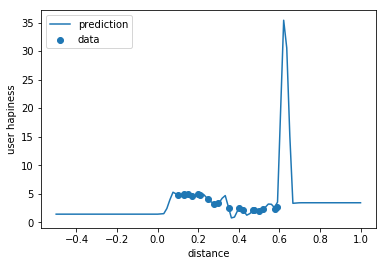

In [64]:
# The prediction goes up!
Plot(train_features['distance'], train_labels, non_monotonic_estimator, -0.5, 1.0)

In [54]:
# Declare distance as a decreasing monotonic input.
hparams.set_feature_param('distance', 'monotonicity', 1)
monotonic_estimator = tfl.calibrated_linear_regressor(
    feature_columns=feature_columns,
    keypoints_initializers_fn=keypoints_init_fns,
    hparams=hparams)

monotonic_estimator.train(input_fn=train_input_fn)

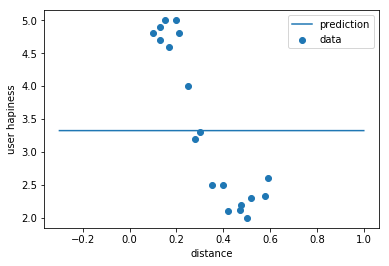

In [55]:
# Now it's decreasing.
Plot(train_features['distance'], train_labels, monotonic_estimator, -0.3, 1.0)

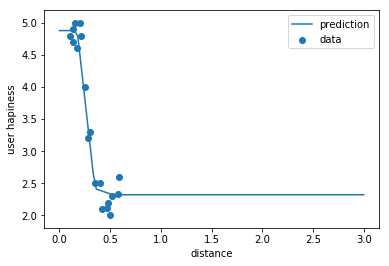

In [11]:
# Even if the output range becomes larger, the prediction never goes up!
Plot(train_features['distance'], train_labels, monotonic_estimator, 0.0, 3.0)